# Downstream prediction 
In this notebook, a HyenaDNA model is used to predict splice site acceptors with a given sequence of nucleotides.

A HyenaDNA model (2 layers and width 256) is used to create embeddings of nucleotides.

A small neural network is then trained, using the embeddings as inputs, to predict if a splice site acceptor is present or not.

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow_addons.metrics import F1Score
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
from datasets import DatasetDict

import datetime
from tqdm import tqdm

/Users/bputzeys/miniforge3/envs/head_example/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/Users/bputzeys/miniforge3/envs/head_example/lib/python3.11/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.13.0-rc1 and is not supported. 
Some things might work, some things might not.
If you were to 

### Use the Helical package to get the Hyena model
We use a small HyenaDNA model with 2 layers and width 256.

In [2]:
from helical.models.hyena_dna.model import HyenaDNA
from helical.models.hyena_dna.hyena_dna_config import HyenaDNAConfig    
configurer = HyenaDNAConfig(model_name="hyenadna-tiny-1k-seqlen-d256")
hyena_model = HyenaDNA(configurer=configurer)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/bputzeys/Documents/Helical/Code_Repos/helical/helical/models/scgpt/model_dir/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
2024-06-03, 14:52:30.751 helical.services.downloader INFO File: '/Users/bputzeys/.cache/helical/models/hyena_dna/hyenadna-tiny-1k-seqlen-d256.ckpt' exists already. File is not overwritten and nothing is downloaded.
2024-06-03, 14:52:30.751 helical.services.downloader INFO File saved to: '/Users/bputzeys/.cache/helical/models/hyena_dna/hyenadna-tiny-1k-seqlen-d256.ckpt'
2024-06-03, 14:52:30.875 helical.models.hyena_dna.pretrained_model INFO Loaded pretrained weights ok!
2024-06-03, 14:52:30.878 helical.models.hyena_dna.model INFO Model finished initializing.


### Download the dataset
Several datasets are available from the [Nucleotide Transformer](https://arxiv.org/abs/2306.15794). Using the get_dataset_config_names() function, we get a list of the available the datasets for the downstream tasks.

In [3]:
from datasets import get_dataset_config_names

configs = get_dataset_config_names("InstaDeepAI/nucleotide_transformer_downstream_tasks")
configs

['H4ac',
 'H3K36me3',
 'splice_sites_donors',
 'splice_sites_acceptors',
 'H3',
 'H4',
 'H3K4me3',
 'splice_sites_all',
 'H3K4me1',
 'H3K14ac',
 'enhancers_types',
 'promoter_no_tata',
 'H3K79me3',
 'H3K4me2',
 'promoter_tata',
 'enhancers',
 'H3K9ac',
 'promoter_all']

Specifically, we are interested in the splice sites acceptors for this notebook:

In [138]:
from datasets import load_dataset
label = "enhancers_types"
dataset = load_dataset("InstaDeepAI/nucleotide_transformer_downstream_tasks", label)

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

To familiarize ourselves with the data, we can print the first seqence and see if it is a splice site acceptor or not:

In [139]:
print("Nucleotide sequence:", dataset["train"]["sequence"][0][:10], "...")
print("Label name:", dataset["train"].config_name, "and value:", dataset["train"]["label"][0])
num_classes = len(set(dataset["train"]["label"]))
print("Number of classes:", num_classes)


Nucleotide sequence: CAGTCACATC ...
Label name: enhancers_types and value: 0
Number of classes: 3


Define a function that gets the embeddings for each nucleotide sequence in the training dataset.

According to the HyenaDNA [paper](https://arxiv.org/pdf/2306.15794): "[they] average across the tokens to obtain a single classification token".

In our code below, the Hyena model returns a (602, 256) matrix. We average column wise resulting in a vector of shape (256, ) for each observation.

During the training process, we also found that it is beneficial to normalize the data row-wise.

In [136]:
def get_model_inputs(dataset: DatasetDict, ratio: float = 1.0):
    
    x = np.empty((0, configurer.config['d_model'])) 
    labels = np.empty((0,), dtype=int)

    # disable logging to avoid cluttering the output
    import logging
    logging.disable(logging.CRITICAL)

    # use tqdm for a progress bar
    length = int(len(dataset)*ratio)
    for i in tqdm(range(length)):
        sequence = dataset["sequence"][i]
        
        tokenized_sequence = hyena_model.process_data(sequence)
        embeddings = hyena_model.get_embeddings(tokenized_sequence)
        
        numpy_array = embeddings[0].detach().numpy()
        mean_array = numpy_array.mean(axis=0)
        x = np.append(x, [mean_array], axis=0)
        
    # normalize the data
    x = (x - np.mean(x, axis=0)) / np.std(x, axis=0)
    labels = np.array(dataset["label"][:length])
    return x, labels

As there are a high number of rows, and thus lots of inferences with the Hyena model, it is beneficial to do this step once and save the output in a `.npy` file.

In [140]:
x, y = get_model_inputs(dataset["train"], 1)
np.save(f"x_{label}_norm_256", x)
np.save(f"y_{label}_norm_256", y)

  1%|          | 108/14968 [00:03<07:01, 35.29it/s]


KeyboardInterrupt: 

Load the data and one-hot-encode the labels.

We split the training set into actual training data and a test set. 

This is optional and the entire dataset can be used for training. We did this to avoid data leakage by not touching the test set during the training process.

In [109]:
x = np.load(f"x_{label}_norm_256.npy")
y = np.load(f"y_{label}_norm_256.npy")

# # One-hot encode the labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_encoded = to_categorical(y_encoded, num_classes=num_classes)

X_train, X_test, y_train, y_test = train_test_split(x, y_encoded, test_size=0.1, random_state=42)

### Define and train the model

In [119]:
input_shape = (configurer.config['d_model'],)

# define the model
head_model = Sequential()

head_model.add(Dense(256, activation='relu', input_shape=input_shape))
head_model.add(Dropout(0.4)) 
head_model.add(Dense(64, activation='relu'))
head_model.add(Dropout(0.4))  
head_model.add(Dense(num_classes, activation='softmax'))

# compile the model
optimizer = Adam(learning_rate=0.001)
f1_score = F1Score(num_classes, average='macro')

head_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=f1_score)
head_model.summary()

# Setup callbacks
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
history = head_model.fit(X_train, y_train, epochs=25, batch_size=64, validation_data=(X_test, y_test), callbacks=[tensorboard_callback])

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 256)               65792     
                                                                 
 dropout_20 (Dropout)        (None, 256)               0         
                                                                 
 dense_31 (Dense)            (None, 64)                16448     
                                                                 
 dropout_21 (Dropout)        (None, 64)                0         
                                                                 
 dense_32 (Dense)            (None, 2)                 130       
                                                                 
Total params: 82370 (321.76 KB)
Trainable params: 82370 (321.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/25
78/7

In [117]:
X_unseen, y_unseen = get_model_inputs(dataset["test"], 1)

100%|██████████| 621/621 [00:15<00:00, 39.24it/s]


### Evaluate the model on the test data


In [120]:
predictions_nn = head_model.predict(X_unseen)

y_pred = np.argmax(predictions_nn, axis=1)
print("Correct predictions: {:.2f}%".format(sum(np.equal(y_pred, y_unseen))*100/len(y_unseen)))


20/20 [==============================] - 0s 339us/step
Correct predictions: 92.11%


The [Hyena](https://arxiv.org/pdf/2306.15794) and the [Nucleotide transformer](https://www.biorxiv.org/content/10.1101/2023.01.11.523679v1.full.pdf) papers, report accuracies around 95% for this task. Our results clearly underperform in comparison. This is probably due to the much larger models being used for the NT, while the Hyena model was re-trained from scratch for this task. In future work, we want to achieve these accuracies too with either approaches.

For reference, we also trained an SVM model and obtained similar results (to our small NN).

In [93]:
# Train the SVM model
svm_model = svm.SVC(kernel='rbf', degree=3, C=1, decision_function_shape='ovr')  # One-vs-rest strategy
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)
svm_model.fit(X_train, y_train)

SVC(C=1)

In [94]:
# Evaluate the model
unseen_predictions_svm = svm_model.predict(X_unseen)

accuracy = accuracy_score(y_unseen, unseen_predictions_svm)
print("Test accuracy: {:.1f}%".format(accuracy*100))


Test accuracy: 91.9%


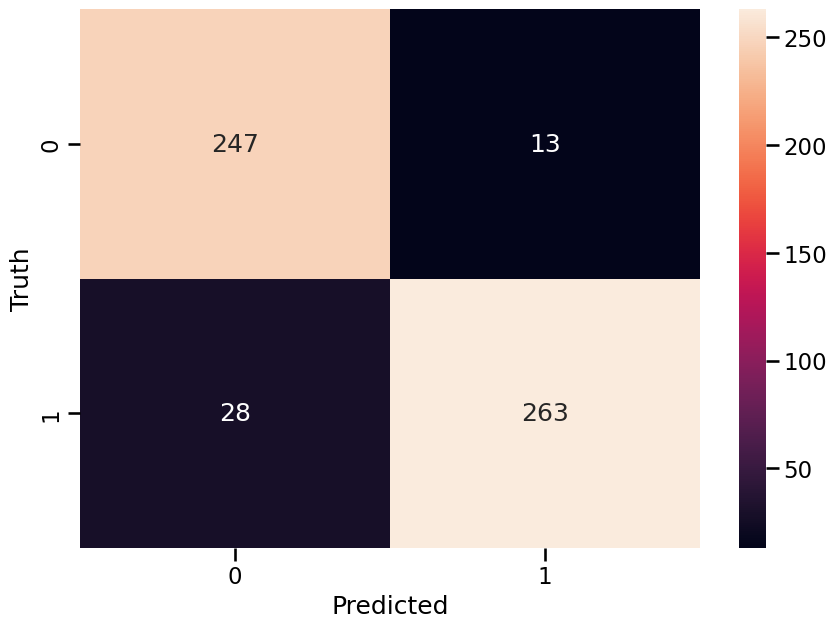

In [95]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# NN
# y_true = np.argmax(y_test, axis=1)
# y_pred_classes = np.argmax(predictions_nn, axis=1)

# SVM
y_true = y_test
y_pred_classes = svm_model.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Create a heatmap
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()